In [11]:
import h5py
import numpy as np
from astropy import units
import getdata

In [36]:
def getdensityprofile(nr_bins = 1000, bin_distr = "adaptive"):
    bin_distr_options = ["linear", "logarithmic", "adaptive"]
    coords = getdata.coordskpc()
    mass = getdata.masssolar()
    
    if(bin_distr not in bin_distr_options):
        print(f"Error: bin_distr contains no valid distribution type. Choose from: " + str(bin_distr_options) + ", performing linear distribution instead.")
        bin_distr = "linear"

    if((nr_bins <= 1) or (isinstance(nr_bins, int) == False)):
        print(f"Error: bin amount must be a positive integer. Will now default to 1000 bins.")
        nr_bins = 1000

    coord_com = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - coord_com
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    bins = np.linspace(r_min, r_max, nr_bins) 
    
    if(bin_distr == "adaptive"):
        com_dist_sorted = np.sort(com_dist)
        nr_particles = len(com_dist_sorted)

        bin_size = nr_particles // nr_bins
        bin_limit = nr_bins*bin_size
        bins = com_dist_sorted[:bin_limit].reshape(nr_bins, bin_size)

        bin_inner_bound = bins[:, 0]         
        bin_outer_bound = bins[:, -1]       
        bin_centre = np.mean(bins, axis=1)  

        bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
        bin_density = bin_size*mass / bin_volume
        bin_poisson_error = np.sqrt(bin_size)*mass / bin_volume
        return bin_centre, bin_density, bin_poisson_error
        
    if(bin_distr == "linear"):
        bins = np.linspace(r_min, r_max, nr_bins)
    if(bin_distr == "logarithmic"):
        bins = np.logspace(np.log10(r_min.value), np.log10(r_max.value), nr_bins) * r_min.unit
    
    bin_counts, bin_edges = np.histogram(com_dist, bins=bins)
    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2
    
    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*mass / bin_volume 
    bin_poisson_error = bin_density / np.sqrt(bin_counts)

    #remove zero density points to avoid logarithmic errors and fit errors
    nonzero_indices = [i for i, density in enumerate(bin_density) if density > 0.0]

    bin_density = [bin_density[i] for i in nonzero_indices] * bin_density.unit
    bin_centre = [bin_centre[i] for i in nonzero_indices] * bin_centre.unit
    bin_poisson_error = [bin_poisson_error[i] for i in nonzero_indices] * bin_poisson_error.unit

    return bin_centre, bin_density, bin_poisson_error

In [58]:
bin_radius, bin_density, bin_poisson = getdensityprofile(nr_bins = 50, bin_distr = "adaptive")
total_mass = (getdata.masssolar() * len(getdata.coordskpc())).to("GsolMass")
bin_radius_average = sum(bin_radius) / len(bin_radius)
print("Guess initial parameters\namp = " + str(total_mass) + "\nlengthscale = " + str(bin_radius_average))

Guess initial parameters
amp = 161.47893455855902 GsolMass
lengthscale = 29.902217518474842 kpc


Try to create a galpy function that fits the calculations

In [131]:
from galpy.potential import TwoPowerSphericalPotential
potential = TwoPowerSphericalPotential(amp=1.408539e+11*units.solMass, a=61.59979773*units.kpc, alpha=2.137631284420001, beta=15.157640182989251)

In [132]:
potential_density_noconvert = potential.dens(bin_radius, z=0.0, phi=0.0, t=0.0, forcepoisson=False)
potential_density_convert = potential.dens(bin_radius, z=0.0, phi=0.0, t=0.0, forcepoisson=False).to("solMass/kpc3")

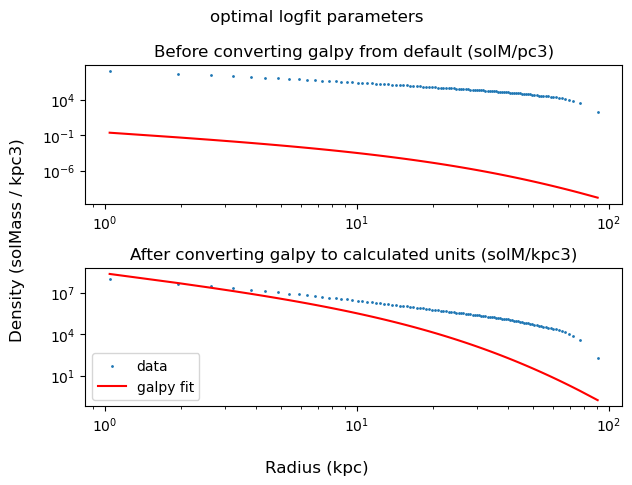

In [133]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=False, sharey=False)

axs[0].scatter(bin_radius, bin_density, s=1, label="data")
axs[0].plot(bin_radius, potential_density_noconvert, c="red", label="galpy fit")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_title("Before converting galpy from default (solM/pc3)")
    
axs[1].scatter(bin_radius, bin_density, s=1, label="data")
axs[1].plot(bin_radius, potential_density_convert, c="red", label="galpy fit")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_title("After converting galpy to calculated units (solM/kpc3)")

fig.supxlabel("Radius (" + str(bin_radius.unit) + ")") 
fig.supylabel("Density (" + str(bin_density.unit) + ")") 
    
plt.suptitle("optimal logfit parameters")
plt.legend()
plt.tight_layout()
plt.show()

This shows that the galpy function itself can also be used for curve_fit potentially

In [134]:
potential = TwoPowerSphericalPotential(amp=total_mass, a=bin_radius_average, alpha=1.5, beta=3.5)
potential_density_noconvert = potential.dens(bin_radius, z=0.0, phi=0.0, t=0.0, forcepoisson=False)
potential_density_convert = potential.dens(bin_radius, z=0.0, phi=0.0, t=0.0, forcepoisson=False).to("solMass/kpc3")

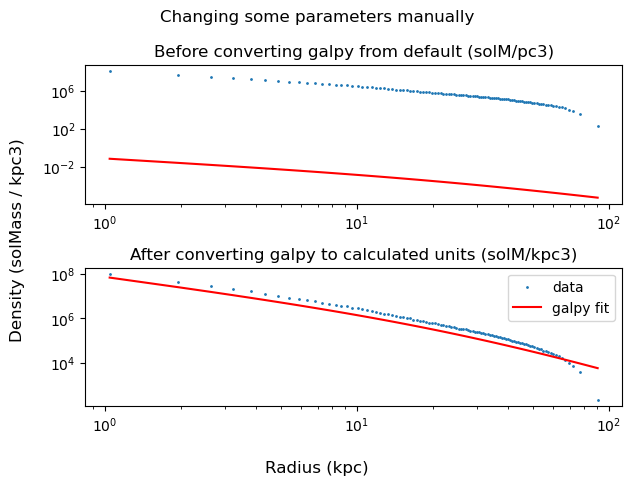

In [135]:
fig, axs = plt.subplots(2, sharex=False, sharey=False)

axs[0].scatter(bin_radius, bin_density, s=1, label="data")
axs[0].plot(bin_radius, potential_density_noconvert, c="red", label="galpy fit")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_title("Before converting galpy from default (solM/pc3)")
    
axs[1].scatter(bin_radius, bin_density, s=1, label="data")
axs[1].plot(bin_radius, potential_density_convert, c="red", label="galpy fit")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_title("After converting galpy to calculated units (solM/kpc3)")

fig.supxlabel("Radius (" + str(bin_radius.unit) + ")") 
fig.supylabel("Density (" + str(bin_density.unit) + ")") 
    
plt.suptitle("Changing some parameters manually")
plt.legend()
plt.tight_layout()
plt.show()